In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 
from statistics import mean
from matplotlib import style
from scipy import stats
#style.use('ggplot')

import matplotlib.colors as colors

In [2]:
#get reference case
case = 'g.e21.G1850ECOIAF.T62_g16.004'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1'
variables = ['diat_Fe_lim_surf', 'diat_P_lim_surf','diat_N_lim_surf','diat_SiO3_lim_surf','photoC_TOT_zint',
             'diat_light_lim_Cweight_avg_100m',
             'diat_light_lim_surf','diat_Fe_lim_Cweight_avg_100m',
             'SiO3','NO3', 'PO4'] 
coords = {'x':'TLONG','y':'TLAT'}

In [3]:
keepthese = ['z_t','z_t_150m','time_bound','TAREA','REGION_MASK', 'time'] + variables

In [4]:
%%time

ds_list = []
print(f'reading {case}')
ds_ref = xr.Dataset()
for v in variables:
    
    print(v)
    
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.000101-006212.nc'))     #just getting the fist IAF
    
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    ds_ref = xr.merge((ds_ref, dsv))
    ds_list.append(ds_ref)

reading g.e21.G1850ECOIAF.T62_g16.004
diat_Fe_lim_surf
diat_P_lim_surf
diat_N_lim_surf
diat_SiO3_lim_surf
photoC_TOT_zint
diat_light_lim_Cweight_avg_100m
diat_light_lim_surf
diat_Fe_lim_Cweight_avg_100m
SiO3
NO3
PO4
CPU times: user 5.36 s, sys: 456 ms, total: 5.82 s
Wall time: 7.49 s


In [5]:
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds_ref = ds_ref.drop([v for v in ds_ref.variables if v not in keep_vars])

In [6]:
tlen=len(ds_ref.time)
#resetting the time variable so that it's a mean of the time bounds
ds_ref["time"] = ds_ref.time_bound.compute().mean(dim="d2")

In [7]:
#just keep the first 20 years for comparison to test runs
ds_ref = ds_ref.isel(time=slice(0,240))
ds_ref

<xarray.Dataset>
Dimensions:                          (d2: 2, nlat: 384, nlon: 320, time: 240, z_t: 60, z_t_150m: 15)
Coordinates:
    TLAT                             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                            (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t_150m                         (z_t_150m) float32 500.0 1500.0 ... 14500.0
  * z_t                              (z_t) float32 500.0 1500.0 ... 537500.0
  * time                             (time) object 0001-01-16 12:59:59 ... 0020-12-16 12:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    TAREA                            (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    REGION_MASK                      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz                               (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                  

Make annual means for these first 20 years

In [8]:
%%time
ds_annmean_ts = ds_ref.resample({'time':'A'}).mean(dim='time').compute()

CPU times: user 3min 9s, sys: 1min, total: 4min 10s
Wall time: 2min 16s


### Now get run that tests the effects of increased alpha PI for diatoms

In [9]:
#get reference case
case = 'g.e21.G1850ECOIAF.T62_g16.005'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1'
variables = ['diat_Fe_lim_surf', 'diat_P_lim_surf','diat_N_lim_surf','diat_SiO3_lim_surf','photoC_TOT_zint',
             'diat_light_lim_Cweight_avg_100m',
             'diat_light_lim_surf','diat_Fe_lim_Cweight_avg_100m',
             'SiO3','NO3', 'PO4'] 
coords = {'x':'TLONG','y':'TLAT'}

In [10]:
%%time

ds_list = []
print(f'reading {case}')
ds_alphapi = xr.Dataset()
for v in variables:
    
    print(v)
    
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.000101-002012.nc'))     #just getting the fist IAF
    
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    ds_alphapi = xr.merge((ds_alphapi, dsv))
    ds_list.append(ds_alphapi)

reading g.e21.G1850ECOIAF.T62_g16.005
diat_Fe_lim_surf
diat_P_lim_surf
diat_N_lim_surf
diat_SiO3_lim_surf
photoC_TOT_zint
diat_light_lim_Cweight_avg_100m
diat_light_lim_surf
diat_Fe_lim_Cweight_avg_100m
SiO3
NO3
PO4
CPU times: user 5.49 s, sys: 146 ms, total: 5.64 s
Wall time: 9.44 s


In [11]:
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds_alphapi = ds_alphapi.drop([v for v in ds_alphapi.variables if v not in keep_vars])

In [12]:
tlen=len(ds_alphapi.time)
#resetting the time variable so that it's a mean of the time bounds
ds_alphapi["time"] = ds_alphapi.time_bound.compute().mean(dim="d2")

In [13]:
%%time
ds_annmean_ts_alphapi = ds_alphapi.resample({'time':'A'}).mean(dim='time').compute()

CPU times: user 2min 54s, sys: 59.7 s, total: 3min 53s
Wall time: 2min 8s


### Now get the run that tests decreasing the diatom maximum grazing rate

In [14]:
#get reference case
case = 'g.e21.G1850ECOIAF.T62_g16.006'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1'
variables = ['diat_Fe_lim_surf', 'diat_P_lim_surf','diat_N_lim_surf','diat_SiO3_lim_surf','photoC_TOT_zint',
             'diat_light_lim_Cweight_avg_100m',
             'diat_light_lim_surf','diat_Fe_lim_Cweight_avg_100m',
             'SiO3','NO3', 'PO4'] 
coords = {'x':'TLONG','y':'TLAT'}

In [15]:
%%time

ds_list = []
print(f'reading {case}')
ds_grz = xr.Dataset()
for v in variables:
    
    print(v)
    
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.000101-002012.nc'))     #just getting the fist IAF
    
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    ds_grz = xr.merge((ds_grz, dsv))
    ds_list.append(ds_grz)

reading g.e21.G1850ECOIAF.T62_g16.006
diat_Fe_lim_surf
diat_P_lim_surf
diat_N_lim_surf
diat_SiO3_lim_surf
photoC_TOT_zint
diat_light_lim_Cweight_avg_100m
diat_light_lim_surf
diat_Fe_lim_Cweight_avg_100m
SiO3
NO3
PO4
CPU times: user 5.6 s, sys: 123 ms, total: 5.72 s
Wall time: 9.58 s


In [16]:
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds_grz = ds_grz.drop([v for v in ds_grz.variables if v not in keep_vars])

In [17]:
tlen=len(ds_grz.time)
#resetting the time variable so that it's a mean of the time bounds
ds_grz["time"] = ds_grz.time_bound.compute().mean(dim="d2")

In [18]:
%%time
ds_annmean_ts_grz = ds_grz.resample({'time':'A'}).mean(dim='time').compute()

CPU times: user 3min, sys: 58.6 s, total: 3min 58s
Wall time: 2min 12s


### Now get the run that tests decreasing k_Fe for diatoms

In [19]:
#get reference case
case = 'g.e21.G1850ECOIAF.T62_g16.007'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1'
variables = ['diat_Fe_lim_surf', 'diat_P_lim_surf','diat_N_lim_surf','diat_SiO3_lim_surf','photoC_TOT_zint',
             'diat_light_lim_Cweight_avg_100m',
             'diat_light_lim_surf','diat_Fe_lim_Cweight_avg_100m',
             'SiO3','NO3', 'PO4'] 
coords = {'x':'TLONG','y':'TLAT'}

In [20]:
%%time

ds_list = []
print(f'reading {case}')
ds_kfe = xr.Dataset()
for v in variables:
    
    print(v)
    
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.000101-002012.nc'))     #just getting the fist IAF
    
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    ds_kfe = xr.merge((ds_kfe, dsv))
    ds_list.append(ds_kfe)

reading g.e21.G1850ECOIAF.T62_g16.007
diat_Fe_lim_surf
diat_P_lim_surf
diat_N_lim_surf
diat_SiO3_lim_surf
photoC_TOT_zint
diat_light_lim_Cweight_avg_100m
diat_light_lim_surf
diat_Fe_lim_Cweight_avg_100m
SiO3
NO3
PO4
CPU times: user 5.42 s, sys: 208 ms, total: 5.63 s
Wall time: 10.6 s


In [21]:
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds_kfe = ds_kfe.drop([v for v in ds_kfe.variables if v not in keep_vars])

In [22]:
tlen=len(ds_kfe.time)
#resetting the time variable so that it's a mean of the time bounds
ds_kfe["time"] = ds_kfe.time_bound.compute().mean(dim="d2")

In [23]:
%%time
ds_annmean_ts_kfe = ds_kfe.resample({'time':'A'}).mean(dim='time').compute()

CPU times: user 2min 53s, sys: 56.2 s, total: 3min 49s
Wall time: 2min 2s


### Get alphaPI case with version of CESM2.2

In [24]:
#get reference case
case = 'g.e21.G1850ECOIAF.T62_g17.001_3pft'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1'
variables = ['diat_Fe_lim_surf', 'diat_P_lim_surf','diat_N_lim_surf','diat_SiO3_lim_surf','photoC_TOT_zint',
             'diat_light_lim_Cweight_avg_100m',
             'diat_light_lim_surf','diat_Fe_lim_Cweight_avg_100m',
             'SiO3','NO3', 'PO4'] 
coords = {'x':'TLONG','y':'TLAT'}

In [29]:
%%time

ds_list = []
print(f'reading {case}')
ds_alphapi2 = xr.Dataset()
for v in variables:
    
    print(v)
    
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.000101-002012.nc'))     #just getting the fist IAF
    
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    ds_alphapi2 = xr.merge((ds_alphapi2, dsv))
    ds_list.append(ds_alphapi2)

reading g.e21.G1850ECOIAF.T62_g17.001_3pft
diat_Fe_lim_surf
diat_P_lim_surf
diat_N_lim_surf
diat_SiO3_lim_surf
photoC_TOT_zint
diat_light_lim_Cweight_avg_100m
diat_light_lim_surf
diat_Fe_lim_Cweight_avg_100m
SiO3
NO3
PO4
CPU times: user 10 s, sys: 198 ms, total: 10.2 s
Wall time: 12.9 s


In [30]:
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds_alphapi2 = ds_alphapi2.drop([v for v in ds_alphapi2.variables if v not in keep_vars])

In [31]:
ds_alphapi2

<xarray.Dataset>
Dimensions:                          (d2: 2, nlat: 384, nlon: 320, time: 240, z_t: 60, z_t_150m: 15)
Coordinates:
    TLAT                             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                            (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t_150m                         (z_t_150m) float32 500.0 1500.0 ... 14500.0
  * z_t                              (z_t) float32 500.0 1500.0 ... 537500.0
  * time                             (time) object 0001-02-01 00:00:00 ... 0021-01-01 00:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    TAREA                            (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    REGION_MASK                      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz                               (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                  

In [32]:
tlen=len(ds_alphapi2.time)
#resetting the time variable so that it's a mean of the time bounds
ds_alphapi2["time"] = ds_alphapi2.time_bound.compute().mean(dim="d2")

In [33]:
%%time
ds_annmean_ts_alphapi2 = ds_alphapi2.resample({'time':'A'}).mean(dim='time').compute()

CPU times: user 2min 53s, sys: 57.5 s, total: 3min 50s
Wall time: 2min 11s


### Get the WOA data

In [34]:
#just getting this for the coords (that don't have nans)
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc'
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_woa['z_t'] = ds_ref.z_t
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01
years = np.arange(len(ds_annmean_ts.time))

In [27]:
woa_SO = xr.Dataset({v: ds_woa[v] for v in ['z_t']})
woa_SO['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
woa_SO['NO3'] = esmlab.weighted_mean(ds_woa['NO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
woa_SO['PO4'] = esmlab.weighted_mean(ds_woa['PO4'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()

### Calculate mean SiO3 bias in the Southern Ocean

In [28]:
#do reference dataset (004)
ts_SO_ref = xr.Dataset({v: ds_annmean_ts[v] for v in ['time','z_t']})
ts_SO_ref['SiO3'] = esmlab.weighted_mean(ds_annmean_ts['SiO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO_ref['NO3'] = esmlab.weighted_mean(ds_annmean_ts['NO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO_ref['PO4'] = esmlab.weighted_mean(ds_annmean_ts['PO4'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()

In [29]:
#do alphapi dataset (005)
ts_SO_alphapi = xr.Dataset({v: ds_annmean_ts_alphapi[v] for v in ['time','z_t']})
ts_SO_alphapi['SiO3'] = esmlab.weighted_mean(ds_annmean_ts_alphapi['SiO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO_alphapi['NO3'] = esmlab.weighted_mean(ds_annmean_ts_alphapi['NO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO_alphapi['PO4'] = esmlab.weighted_mean(ds_annmean_ts_alphapi['PO4'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()

In [30]:
#do grz dataset (006)
ts_SO_grz = xr.Dataset({v: ds_annmean_ts_grz[v] for v in ['time','z_t']})
ts_SO_grz['SiO3'] = esmlab.weighted_mean(ds_annmean_ts_grz['SiO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO_grz['NO3'] = esmlab.weighted_mean(ds_annmean_ts_grz['NO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO_grz['PO4'] = esmlab.weighted_mean(ds_annmean_ts_grz['PO4'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()

In [31]:
#do kfe dataset (007)
ts_SO_kfe = xr.Dataset({v: ds_annmean_ts_kfe[v] for v in ['time','z_t']})
ts_SO_kfe['SiO3'] = esmlab.weighted_mean(ds_annmean_ts_kfe['SiO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO_kfe['SiO3'] = esmlab.weighted_mean(ds_annmean_ts_kfe['SiO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO_kfe['PO4'] = esmlab.weighted_mean(ds_annmean_ts_kfe['PO4'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()

In [ ]:
#do alphapi2 dataset
ts_SO_alphapi2 = xr.Dataset({v: ds_annmean_ts_alphapi2[v] for v in ['time','z_t']})
ts_SO_alphapi2['SiO3'] = esmlab.weighted_mean(ds_annmean_ts_alphapi2['SiO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO_alphapi2['NO3'] = esmlab.weighted_mean(ds_annmean_ts_alphapi2['NO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO_alphapi2['PO4'] = esmlab.weighted_mean(ds_annmean_ts_alphapi2['PO4'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()

In [32]:
diff_SO_ref = ts_SO_ref - woa_SO
diff_SO_ref=diff_SO_ref.transpose()
diff_SO_ref_top=diff_SO_ref.isel(z_t=slice(0,40))
diff_SO_ref_bottom=diff_SO_ref.isel(z_t=slice(40,60))

In [33]:
diff_SO_alphapi = ts_SO_alphapi - woa_SO
diff_SO_alphapi=diff_SO_alphapi.transpose()
diff_SO_alphapi_top=diff_SO_alphapi.isel(z_t=slice(0,40))
diff_SO_alphapi_bottom=diff_SO_alphapi.isel(z_t=slice(40,60))

In [34]:
diff_SO_grz = ts_SO_grz - woa_SO
diff_SO_grz=diff_SO_grz.transpose()
diff_SO_grz_top=diff_SO_grz.isel(z_t=slice(0,40))
diff_SO_grz_bottom=diff_SO_grz.isel(z_t=slice(40,60))

In [35]:
diff_SO_kfe = ts_SO_kfe - woa_SO
diff_SO_kfe=diff_SO_kfe.transpose()
diff_SO_kfe_top=diff_SO_kfe.isel(z_t=slice(0,40))
diff_SO_kfe_bottom=diff_SO_kfe.isel(z_t=slice(40,60))

In [ ]:
diff_SO_alphapi2 = ts_SO_alphapi2 - woa_SO
diff_SO_alphapi2=diff_SO_alphapi2.transpose()
diff_SO_alphapi2_top=diff_SO_alphapi2.isel(z_t=slice(0,40))
diff_SO_alphapi2_bottom=diff_SO_alphapi2.isel(z_t=slice(40,60))

In [34]:
z_top=depths.isel(z_t=slice(0,40))
z_bottom=depths.isel(z_t=slice(40,60))

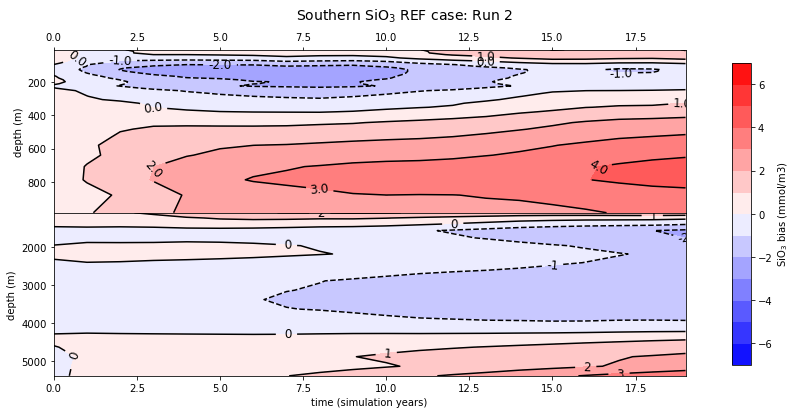

In [37]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Southern SiO$_3$ REF case: Run 2', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7]
pc=ax.contourf(years, z_top, diff_SO_ref_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_SO_ref_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_SO_ref_bottom['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_SO_ref_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ bias (mmol/m3)')

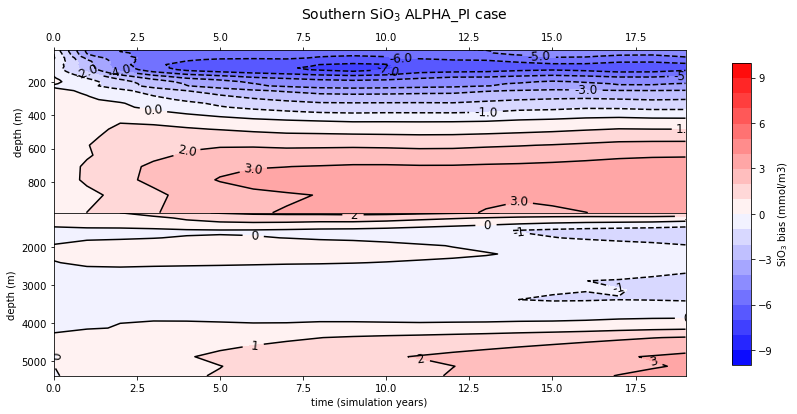

In [38]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Southern SiO$_3$ ALPHA_PI case', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10]
pc=ax.contourf(years, z_top, diff_SO_alphapi_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_SO_alphapi_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_SO_alphapi_bottom['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_SO_alphapi_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ bias (mmol/m3)')

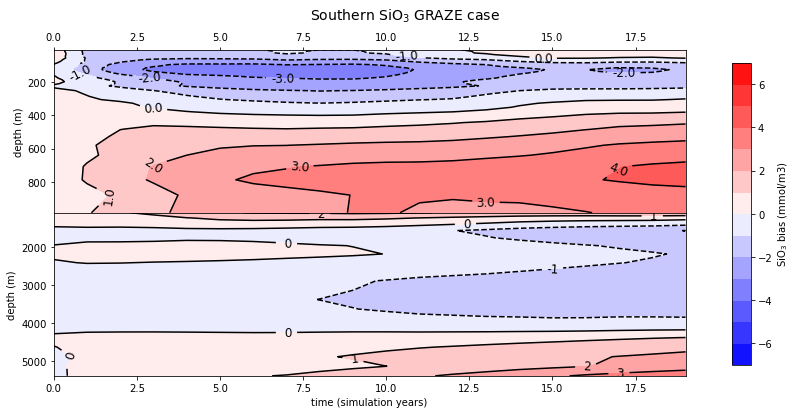

In [39]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Southern SiO$_3$ GRAZE case', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7]
pc=ax.contourf(years, z_top, diff_SO_grz_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_SO_grz_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_SO_grz_bottom['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_SO_grz_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ bias (mmol/m3)')

In [40]:
#diff_SO_kfe_top['SiO3']

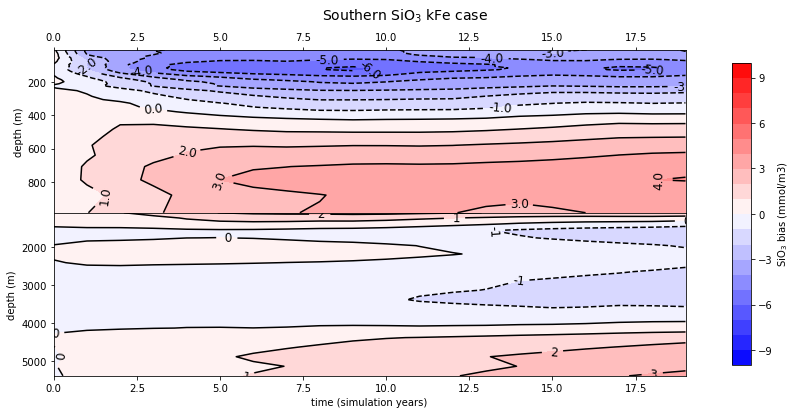

In [41]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Southern SiO$_3$ kFe case', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10]
pc=ax.contourf(years, z_top, diff_SO_kfe_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_SO_kfe_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_SO_kfe_bottom['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_SO_kfe_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ bias (mmol/m3)')

In [ ]:
#alphapi2 case
fig = plt.figure(figsize=(13,6))

plt.suptitle('Southern SiO$_3$ alphapi2 case', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10]
pc=ax.contourf(years, z_top, diff_SO_alphapi2_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_SO_alphapi2_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_SO_alphapi2_bottom['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_SO_alphapi2_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ bias (mmol/m3)')


### Look at top 1000m all together

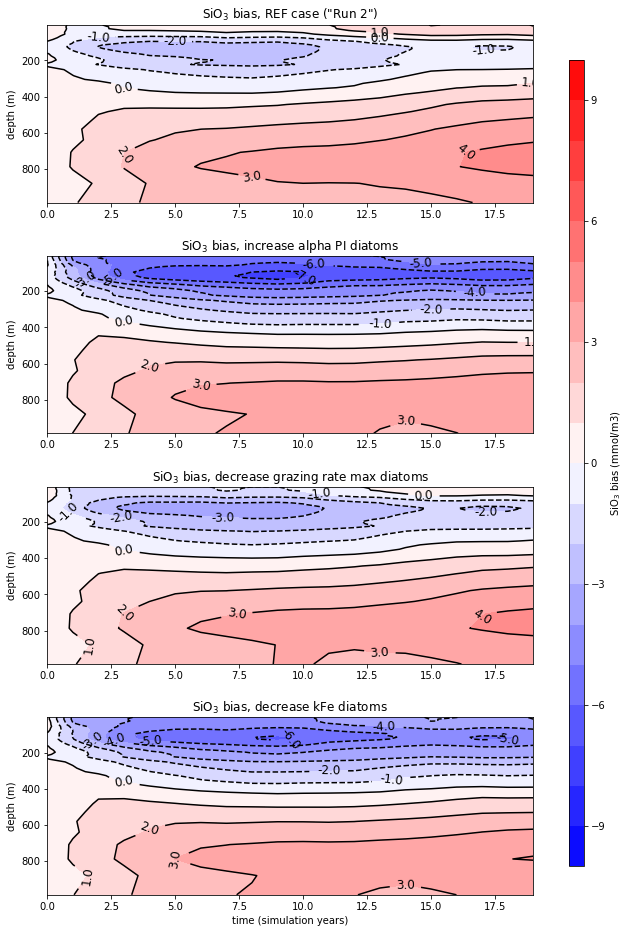

In [42]:
fig = plt.figure(figsize=(10,16))

#plt.title('Southern SiO$_3$ REF case: Run 2', fontsize=14)
levels = [-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10]

ax = fig.add_subplot(4,1,1)
pc=ax.contourf(years, z_top, diff_SO_ref_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_SO_ref_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.set_title('SiO$_3$ bias, REF case ("Run 2")')

fig.subplots_adjust(right=0.8,hspace=0.3)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ bias (mmol/m3)')

#----------------------------------
ax = fig.add_subplot(4,1,2)
pc=ax.contourf(years, z_top, diff_SO_alphapi_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_SO_alphapi_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.set_title('SiO$_3$ bias, increase alpha PI diatoms')



#----------------------------------
ax = fig.add_subplot(4,1,3)
pc=ax.contourf(years, z_top, diff_SO_grz_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_SO_grz_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.set_title('SiO$_3$ bias, decrease grazing rate max diatoms')


#----------------------------------
ax = fig.add_subplot(4,1,4)
pc=ax.contourf(years, z_top, diff_SO_kfe_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_SO_kfe_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()
ax.set_title('SiO$_3$ bias, decrease kFe diatoms');




#### Look at drift in SiO3 in the top 100m

In [43]:
ts_100m_ref = ts_SO_ref.isel(z_t=slice(0,10)).mean(dim='z_t')

In [44]:
ts_100m_alphapi = ts_SO_alphapi.isel(z_t=slice(0,10)).mean(dim='z_t')

In [45]:
ts_100m_grz = ts_SO_grz.isel(z_t=slice(0,10)).mean(dim='z_t')

In [46]:
ts_100m_kfe = ts_SO_kfe.isel(z_t=slice(0,10)).mean(dim='z_t')

In [47]:
woa_100m = woa_SO.isel(z_t=slice(0,10)).mean(dim='z_t')
woa_100m

<xarray.Dataset>
Dimensions:  ()
Data variables:
    SiO3     float64 16.59
    NO3      float64 14.12
    PO4      float64 1.09

In [48]:
woa_timevals=np.array([ 0., 20.])
woa_vals=np.array([ woa_100m.SiO3.values, woa_100m.SiO3.values])

[Text(0, 0.5, 'SiO$_3$ (mmol m$^{-3}$)'), Text(0.5, 0, 'year of simulation')]

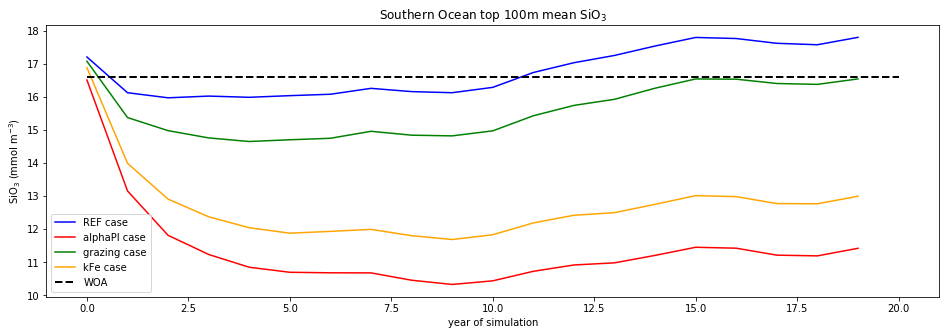

In [49]:
fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Southern Ocean top 100m mean SiO$_3$')
ax.plot(years,ts_100m_ref['SiO3'],color='blue',label='REF case')
ax.plot(years,ts_100m_alphapi['SiO3'],color='red',label='alphaPI case')
ax.plot(years,ts_100m_grz['SiO3'],color='green',label='grazing case')
ax.plot(years,ts_100m_kfe['SiO3'],color='orange',label='kFe case')
ax.plot(woa_timevals,woa_vals,'--', linewidth=2,color='black',label='WOA')
ax.legend()
ax.set(ylabel='SiO$_3$ (mmol m$^{-3}$)',xlabel='year of simulation')

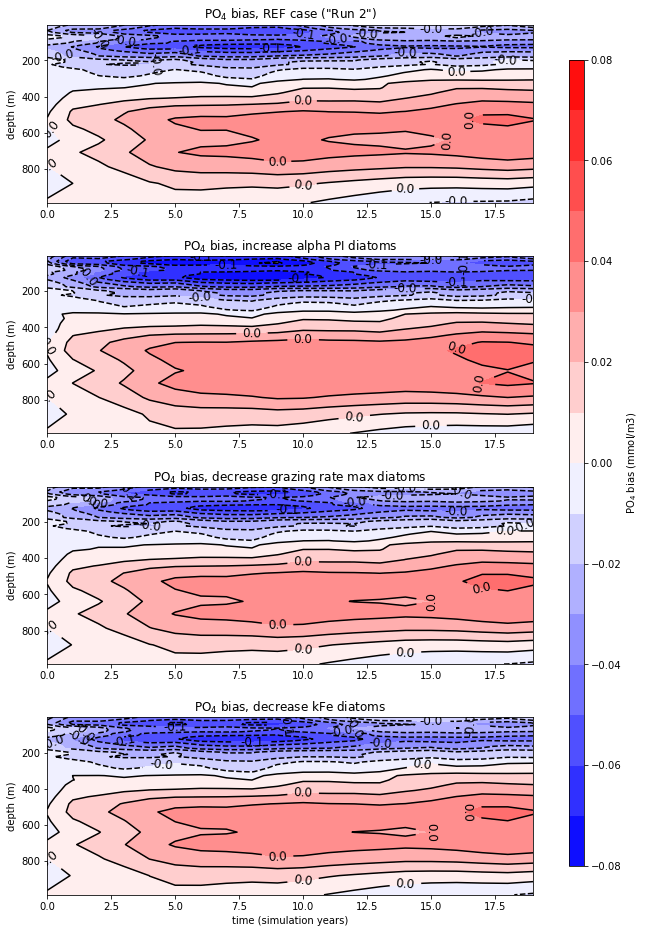

In [50]:
fig = plt.figure(figsize=(10,16))

#plt.title('Southern SiO$_3$ REF case: Run 2', fontsize=14)
levels = [-0.08,-0.07,-0.06,-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08]

ax = fig.add_subplot(4,1,1)
pc=ax.contourf(years, z_top, diff_SO_ref_top['PO4'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_SO_ref_top['PO4'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.set_title('PO$_4$ bias, REF case ("Run 2")')

fig.subplots_adjust(right=0.8,hspace=0.3)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='PO$_4$ bias (mmol/m3)')

#----------------------------------
ax = fig.add_subplot(4,1,2)
pc=ax.contourf(years, z_top, diff_SO_alphapi_top['PO4'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_SO_alphapi_top['PO4'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.set_title('PO$_4$ bias, increase alpha PI diatoms')



#----------------------------------
ax = fig.add_subplot(4,1,3)
pc=ax.contourf(years, z_top, diff_SO_grz_top['PO4'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_SO_grz_top['PO4'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.set_title('PO$_4$ bias, decrease grazing rate max diatoms')


#----------------------------------
ax = fig.add_subplot(4,1,4)
pc=ax.contourf(years, z_top, diff_SO_kfe_top['PO4'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_SO_kfe_top['PO4'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()
ax.set_title('PO$_4$ bias, decrease kFe diatoms');



### Examine other areas of the ocean

First, look at differences globally

In [28]:
woa_global = xr.Dataset({v: ds_woa[v] for v in ['z_t']})
woa_global['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3'], weights=area, dim=['nlat', 'nlon']).compute()
woa_global['NO3'] = esmlab.weighted_mean(ds_woa['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
woa_global['PO4'] = esmlab.weighted_mean(ds_woa['PO4'], weights=area, dim=['nlat', 'nlon']).compute()

In [29]:
#do reference dataset (004)
ts_global_ref = xr.Dataset({v: ds_annmean_ts[v] for v in ['time','z_t']})
ts_global_ref['SiO3'] = esmlab.weighted_mean(ds_annmean_ts['SiO3'], weights=area, dim=['nlat', 'nlon']).compute()
ts_global_ref['NO3'] = esmlab.weighted_mean(ds_annmean_ts['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
ts_global_ref['PO4'] = esmlab.weighted_mean(ds_annmean_ts['PO4'], weights=area, dim=['nlat', 'nlon']).compute()

In [30]:
#do alphapi dataset (005)
ts_global_alphapi = xr.Dataset({v: ds_annmean_ts[v] for v in ['time','z_t']})
ts_global_alphapi['SiO3'] = esmlab.weighted_mean(ds_annmean_ts_alphapi['SiO3'], weights=area, dim=['nlat', 'nlon']).compute()
ts_global_alphapi['NO3'] = esmlab.weighted_mean(ds_annmean_ts_alphapi['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
ts_global_alphapi['PO4'] = esmlab.weighted_mean(ds_annmean_ts_alphapi['PO4'], weights=area, dim=['nlat', 'nlon']).compute()

In [31]:
#do grz dataset (006)
ts_global_grz = xr.Dataset({v: ds_annmean_ts[v] for v in ['time','z_t']})
ts_global_grz['SiO3'] = esmlab.weighted_mean(ds_annmean_ts_grz['SiO3'], weights=area, dim=['nlat', 'nlon']).compute()
ts_global_grz['NO3'] = esmlab.weighted_mean(ds_annmean_ts_grz['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
ts_global_grz['PO4'] = esmlab.weighted_mean(ds_annmean_ts_grz['PO4'], weights=area, dim=['nlat', 'nlon']).compute()

In [32]:
#do kfe dataset (007)
ts_global_kfe = xr.Dataset({v: ds_annmean_ts[v] for v in ['time','z_t']})
ts_global_kfe['SiO3'] = esmlab.weighted_mean(ds_annmean_ts_kfe['SiO3'], weights=area, dim=['nlat', 'nlon']).compute()
ts_global_kfe['NO3'] = esmlab.weighted_mean(ds_annmean_ts_kfe['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
ts_global_kfe['PO4'] = esmlab.weighted_mean(ds_annmean_ts_kfe['PO4'], weights=area, dim=['nlat', 'nlon']).compute()

In [41]:
diff_global_ref = ts_global_ref - woa_global
diff_global_ref=diff_global_ref.transpose()
diff_global_ref_top=diff_global_ref.isel(z_t=slice(0,40))
diff_global_ref_bottom=diff_global_ref.isel(z_t=slice(40,60))

In [42]:
diff_global_alphapi = ts_global_alphapi - woa_global
diff_global_alphapi=diff_global_alphapi.transpose()
diff_global_alphapi_top=diff_global_alphapi.isel(z_t=slice(0,40))
diff_global_alphapi_bottom=diff_global_alphapi.isel(z_t=slice(40,60))

In [43]:
diff_global_grz = ts_global_grz - woa_global
diff_global_grz=diff_global_grz.transpose()
diff_global_grz_top=diff_global_grz.isel(z_t=slice(0,40))
diff_global_grz_bottom=diff_global_grz.isel(z_t=slice(40,60))

In [44]:
diff_global_kfe = ts_global_kfe - woa_global
diff_global_kfe=diff_global_kfe.transpose()
diff_global_kfe_top=diff_global_kfe.isel(z_t=slice(0,40))
diff_global_kfe_bottom=diff_global_kfe.isel(z_t=slice(40,60))

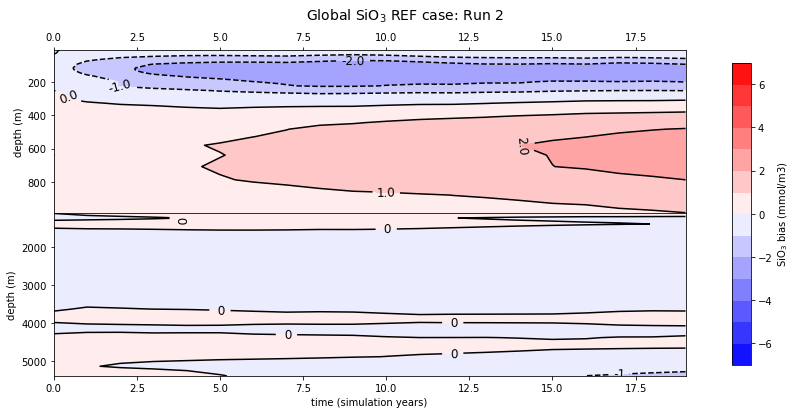

In [45]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Global SiO$_3$ REF case: Run 2', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7]
pc=ax.contourf(years, z_top, diff_global_ref_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_global_ref_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_global_ref_bottom['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_global_ref_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ bias (mmol/m3)')

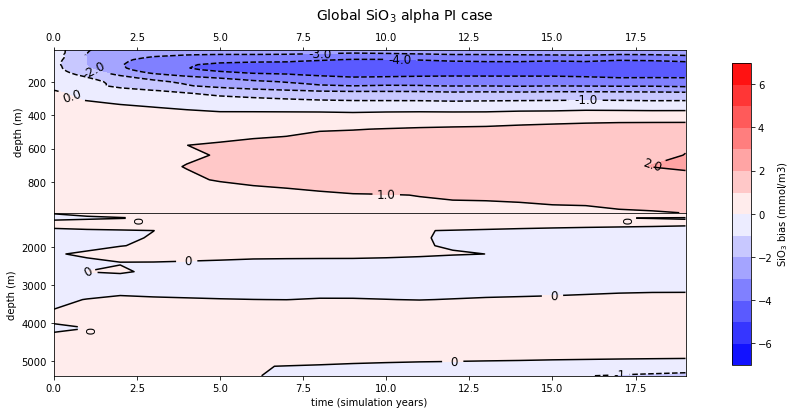

In [46]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Global SiO$_3$ alpha PI case', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7]
pc=ax.contourf(years, z_top, diff_global_alphapi_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_global_alphapi_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_global_alphapi_bottom['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_global_alphapi_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ bias (mmol/m3)')

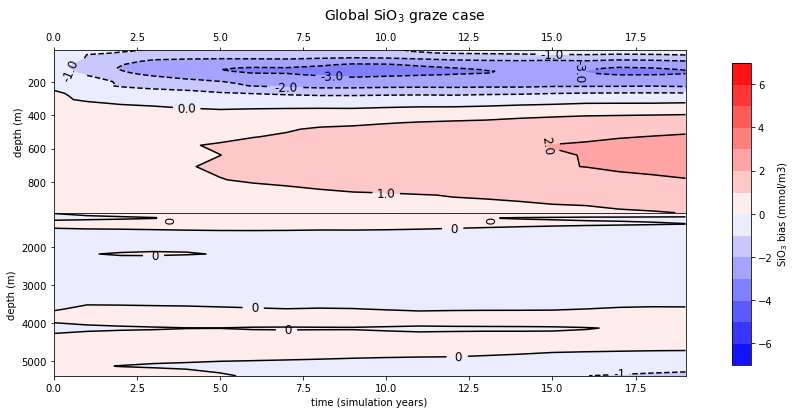

In [47]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Global SiO$_3$ graze case', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7]
pc=ax.contourf(years, z_top, diff_global_grz_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_global_grz_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_global_grz_bottom['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_global_grz_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ bias (mmol/m3)')

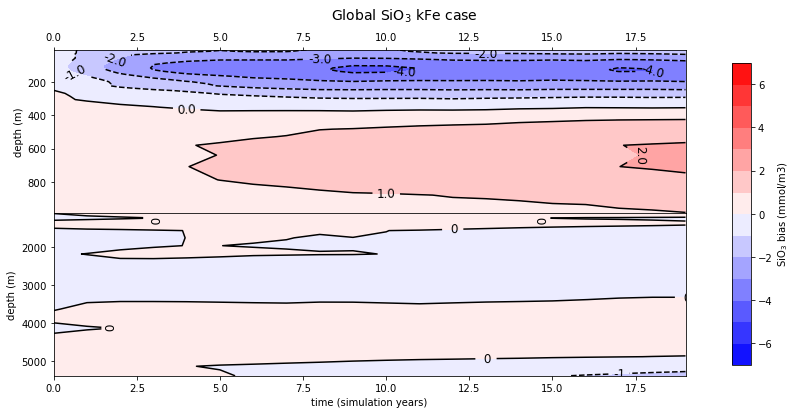

In [48]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Global SiO$_3$ kFe case', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7]
pc=ax.contourf(years, z_top, diff_global_kfe_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_global_kfe_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_global_kfe_bottom['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_global_kfe_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ bias (mmol/m3)')

Now let's look in the different basins

In [26]:
grid_name = 'POP_gx1v7'
ds_regmasks = pop_tools.get_grid(grid_name)

In [27]:
region_masks = pop_tools.list_region_masks(grid_name)
region_mask='Pacific-Indian-Atlantic'
mask3d = pop_tools.region_mask_3d(grid_name, mask_name=region_mask)

#### Pacific

In [53]:
woa_Pac = xr.Dataset({v: ds_woa[v] for v in ['z_t']})
regnum=2
woa_Pac['NO3'] = esmlab.weighted_mean(ds_woa['NO3']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
woa_Pac['PO4'] = esmlab.weighted_mean(ds_woa['PO4']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
woa_Pac['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()

In [51]:
%%time
regnum=2
ts_Pac = xr.Dataset({v: ds_annmean_ts[v] for v in ['time','z_t']})
ts_Pac['PO4'] = esmlab.weighted_mean(ds_annmean_ts['PO4']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac['NO3'] = esmlab.weighted_mean(ds_annmean_ts['NO3']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac['SiO3'] = esmlab.weighted_mean(ds_annmean_ts['SiO3']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()

CPU times: user 5.27 s, sys: 6.52 s, total: 11.8 s
Wall time: 11.8 s


In [52]:
%%time
regnum=2
ts_Pac_alphapi = xr.Dataset({v: ds_annmean_ts[v] for v in ['time','z_t']})
ts_Pac_alphapi['PO4'] = esmlab.weighted_mean(ds_annmean_ts_alphapi['PO4']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac_alphapi['NO3'] = esmlab.weighted_mean(ds_annmean_ts_alphapi['NO3']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac_alphapi['SiO3'] = esmlab.weighted_mean(ds_annmean_ts_alphapi['SiO3']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()

CPU times: user 5.24 s, sys: 6.52 s, total: 11.8 s
Wall time: 11.7 s


In [54]:
%%time
regnum=2
ts_Pac_grz = xr.Dataset({v: ds_annmean_ts[v] for v in ['time','z_t']})
ts_Pac_grz['PO4'] = esmlab.weighted_mean(ds_annmean_ts_grz['PO4']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac_grz['NO3'] = esmlab.weighted_mean(ds_annmean_ts_grz['NO3']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac_grz['SiO3'] = esmlab.weighted_mean(ds_annmean_ts_grz['SiO3']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()

CPU times: user 5.36 s, sys: 6.38 s, total: 11.7 s
Wall time: 11.7 s


In [55]:
%%time
regnum=2
ts_Pac_kfe = xr.Dataset({v: ds_annmean_ts[v] for v in ['time','z_t']})
ts_Pac_kfe['PO4'] = esmlab.weighted_mean(ds_annmean_ts_kfe['PO4']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac_kfe['NO3'] = esmlab.weighted_mean(ds_annmean_ts_kfe['NO3']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac_kfe['SiO3'] = esmlab.weighted_mean(ds_annmean_ts_kfe['SiO3']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()

CPU times: user 5.28 s, sys: 6.52 s, total: 11.8 s
Wall time: 11.8 s


In [62]:
diff_Pac_ref = ts_Pac - woa_Pac
diff_Pac_ref=diff_Pac_ref.transpose()
diff_Pac_ref_top=diff_Pac_ref.isel(z_t=slice(0,40))
diff_Pac_ref_bottom=diff_Pac_ref.isel(z_t=slice(40,60))

In [63]:
diff_Pac_alphapi = ts_Pac_alphapi - woa_Pac
diff_Pac_alphapi=diff_Pac_alphapi.transpose()
diff_Pac_alphapi_top=diff_Pac_alphapi.isel(z_t=slice(0,40))
diff_Pac_alphapi_bottom=diff_Pac_alphapi.isel(z_t=slice(40,60))

In [64]:
diff_Pac_grz = ts_Pac_grz - woa_Pac
diff_Pac_grz = diff_Pac_grz.transpose()
diff_Pac_grz_top=diff_Pac_grz.isel(z_t=slice(0,40))
diff_Pac_grz_bottom=diff_Pac_grz.isel(z_t=slice(40,60))

In [65]:
diff_Pac_kfe = ts_Pac_kfe - woa_Pac
diff_Pac_kfe = diff_Pac_kfe.transpose()
diff_Pac_kfe_top=diff_Pac_kfe.isel(z_t=slice(0,40))
diff_Pac_kfe_bottom=diff_Pac_kfe.isel(z_t=slice(40,60))

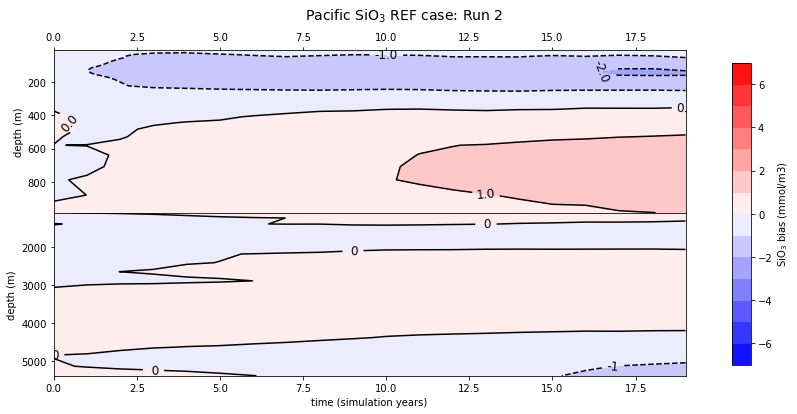

In [66]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Pacific SiO$_3$ REF case: Run 2', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7]
pc=ax.contourf(years, z_top, diff_Pac_ref_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_Pac_ref_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Pac_ref_bottom['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_Pac_ref_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ bias (mmol/m3)')

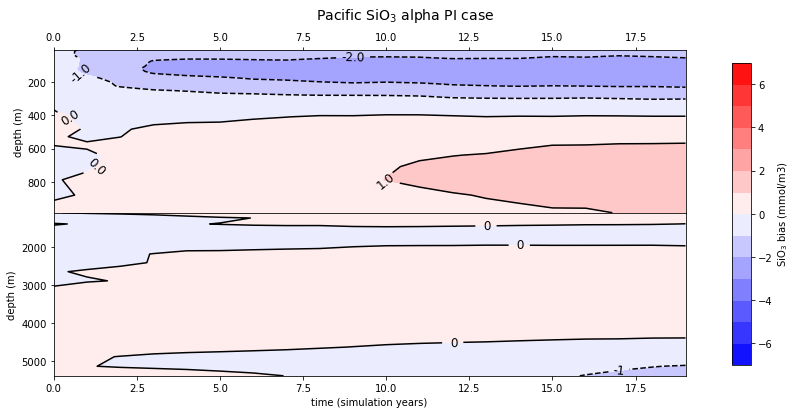

In [68]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Pacific SiO$_3$ alpha PI case', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7]
pc=ax.contourf(years, z_top, diff_Pac_alphapi_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_Pac_alphapi_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Pac_alphapi_bottom['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_Pac_alphapi_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ bias (mmol/m3)')

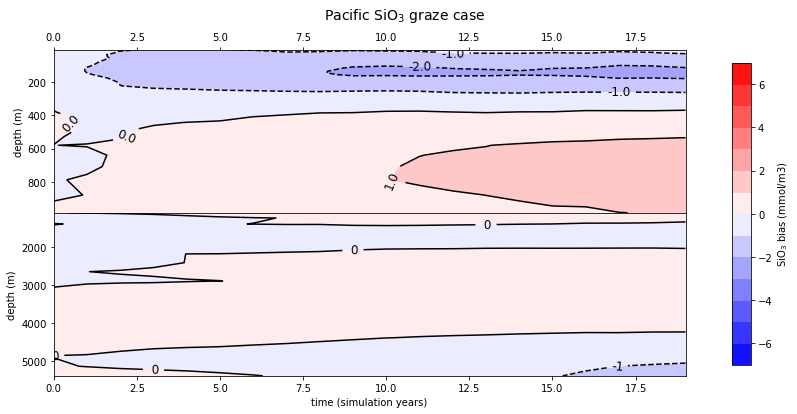

In [69]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Pacific SiO$_3$ graze case', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7]
pc=ax.contourf(years, z_top, diff_Pac_grz_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_Pac_grz_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Pac_grz_bottom['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_Pac_grz_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ bias (mmol/m3)')

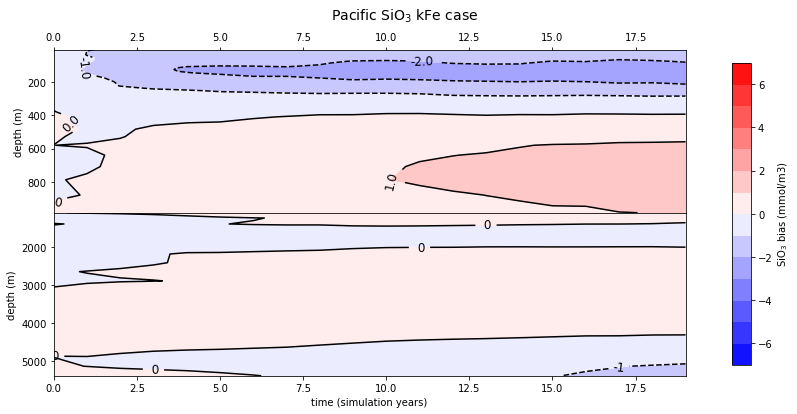

In [70]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Pacific SiO$_3$ kFe case', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7]
pc=ax.contourf(years, z_top, diff_Pac_kfe_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_Pac_kfe_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Pac_kfe_bottom['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_Pac_kfe_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ bias (mmol/m3)')

* Some of the negative bias in the surface could be due to the Southern Ocean being averaged in

#### Alantic

In [28]:
woa_Atl = xr.Dataset({v: ds_woa[v] for v in ['z_t']})
regnum=1
woa_Atl['NO3'] = esmlab.weighted_mean(ds_woa['NO3']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
woa_Atl['PO4'] = esmlab.weighted_mean(ds_woa['PO4']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
woa_Atl['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()

In [29]:
%%time
regnum=1
ts_Atl = xr.Dataset({v: ds_annmean_ts[v] for v in ['time','z_t']})
ts_Atl['PO4'] = esmlab.weighted_mean(ds_annmean_ts['PO4']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Atl['NO3'] = esmlab.weighted_mean(ds_annmean_ts['NO3']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Atl['SiO3'] = esmlab.weighted_mean(ds_annmean_ts['SiO3']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()

CPU times: user 5.86 s, sys: 7.53 s, total: 13.4 s
Wall time: 13.4 s


In [30]:
%%time
regnum=1
ts_Atl_alphapi = xr.Dataset({v: ds_annmean_ts[v] for v in ['time','z_t']})
ts_Atl_alphapi['PO4'] = esmlab.weighted_mean(ds_annmean_ts_alphapi['PO4']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Atl_alphapi['NO3'] = esmlab.weighted_mean(ds_annmean_ts_alphapi['NO3']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Atl_alphapi['SiO3'] = esmlab.weighted_mean(ds_annmean_ts_alphapi['SiO3']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()

CPU times: user 6.07 s, sys: 7.41 s, total: 13.5 s
Wall time: 13.5 s


In [31]:
%%time
regnum=1
ts_Atl_grz = xr.Dataset({v: ds_annmean_ts[v] for v in ['time','z_t']})
ts_Atl_grz['PO4'] = esmlab.weighted_mean(ds_annmean_ts_grz['PO4']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Atl_grz['NO3'] = esmlab.weighted_mean(ds_annmean_ts_grz['NO3']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Atl_grz['SiO3'] = esmlab.weighted_mean(ds_annmean_ts_grz['SiO3']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()

CPU times: user 5.72 s, sys: 7.68 s, total: 13.4 s
Wall time: 13.4 s


In [32]:
%%time
regnum=1
ts_Atl_kfe = xr.Dataset({v: ds_annmean_ts[v] for v in ['time','z_t']})
ts_Atl_kfe['PO4'] = esmlab.weighted_mean(ds_annmean_ts_kfe['PO4']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Atl_kfe['NO3'] = esmlab.weighted_mean(ds_annmean_ts_kfe['NO3']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Atl_kfe['SiO3'] = esmlab.weighted_mean(ds_annmean_ts_kfe['SiO3']*mask3d.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()

CPU times: user 5.69 s, sys: 7.59 s, total: 13.3 s
Wall time: 13.3 s


In [36]:
diff_Atl_ref = ts_Atl - woa_Atl
diff_Atl_ref=diff_Atl_ref.transpose()
diff_Atl_ref_top=diff_Atl_ref.isel(z_t=slice(0,40))
diff_Atl_ref_bottom=diff_Atl_ref.isel(z_t=slice(40,60))

In [37]:
diff_Atl_alphapi = ts_Atl_alphapi - woa_Atl
diff_Atl_alphapi=diff_Atl_alphapi.transpose()
diff_Atl_alphapi_top=diff_Atl_alphapi.isel(z_t=slice(0,40))
diff_Atl_alphapi_bottom=diff_Atl_alphapi.isel(z_t=slice(40,60))

In [42]:
diff_Atl_grz = ts_Atl_grz - woa_Atl
diff_Atl_grz=diff_Atl_grz.transpose()
diff_Atl_grz_top=diff_Atl_grz.isel(z_t=slice(0,40))
diff_Atl_grz_bottom=diff_Atl_grz.isel(z_t=slice(40,60))

In [43]:
diff_Atl_kfe = ts_Atl_kfe - woa_Atl
diff_Atl_kfe=diff_Atl_kfe.transpose()
diff_Atl_kfe_top=diff_Atl_kfe.isel(z_t=slice(0,40))
diff_Atl_kfe_bottom=diff_Atl_kfe.isel(z_t=slice(40,60))

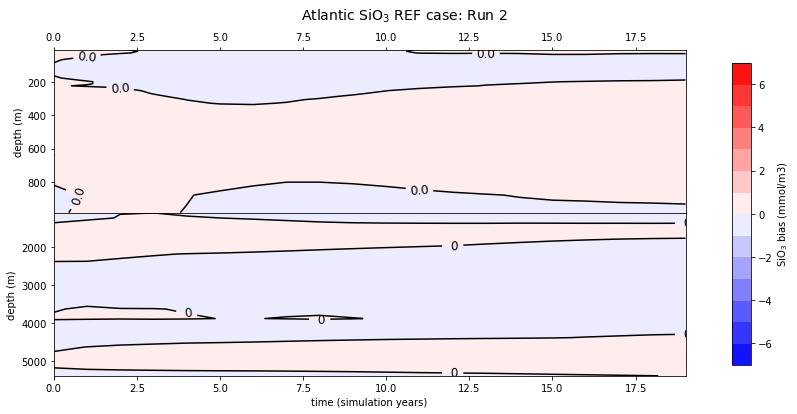

In [38]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Atlantic SiO$_3$ REF case: Run 2', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7]
pc=ax.contourf(years, z_top, diff_Atl_ref_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_Atl_ref_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Atl_ref_bottom['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_Atl_ref_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ bias (mmol/m3)')

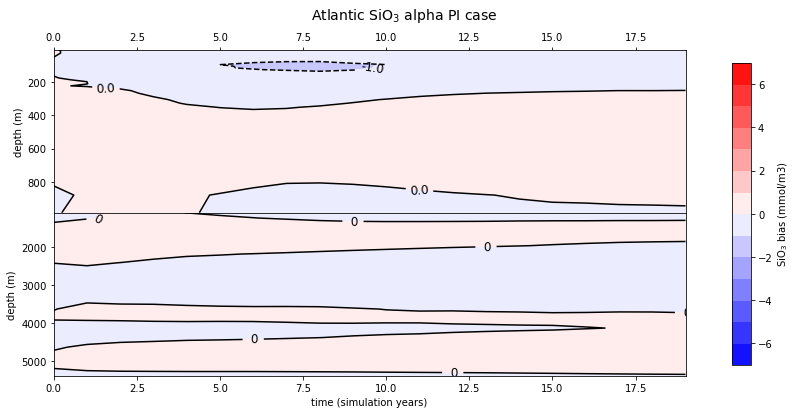

In [40]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Atlantic SiO$_3$ alpha PI case', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7]
pc=ax.contourf(years, z_top, diff_Atl_alphapi_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_Atl_alphapi_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Atl_alphapi_bottom['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_Atl_alphapi_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ bias (mmol/m3)')

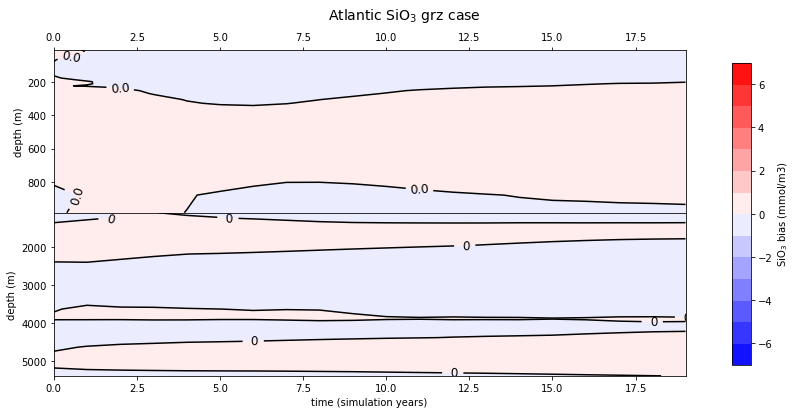

In [44]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Atlantic SiO$_3$ grz case', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7]
pc=ax.contourf(years, z_top, diff_Atl_grz_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_Atl_grz_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Atl_grz_bottom['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_Atl_grz_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ bias (mmol/m3)')

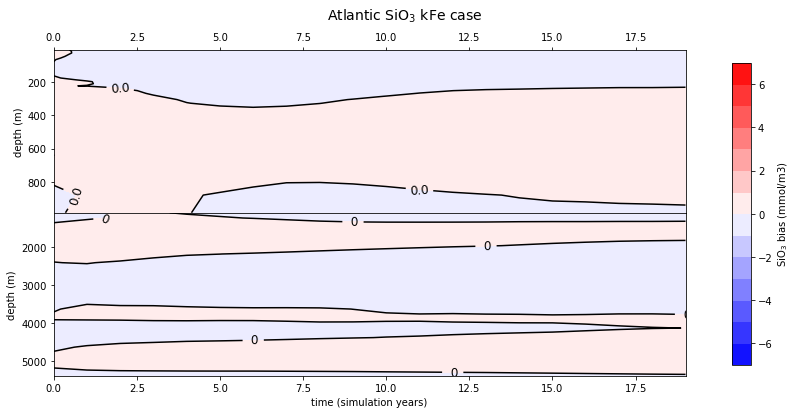

In [45]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Atlantic SiO$_3$ kFe case', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7]
pc=ax.contourf(years, z_top, diff_Atl_kfe_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_Atl_kfe_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Atl_kfe_bottom['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_Atl_kfe_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ bias (mmol/m3)')

#### Try basins without the Southern OCean

In [49]:
reg_mask = ds_annmean_ts_alphapi.REGION_MASK.isel(time=0)

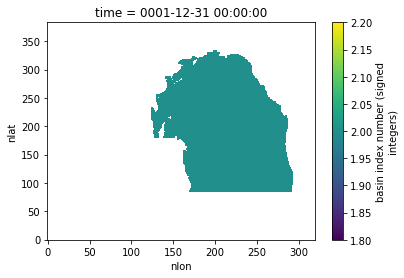

In [51]:
reg_mask.where(reg_mask==2).plot()

In [52]:
woa_Pac2 = xr.Dataset({v: ds_woa[v] for v in ['z_t']})
woa_Pac2['NO3'] = esmlab.weighted_mean(ds_woa['NO3'].where(reg_mask==2), weights=area, dim=['nlat', 'nlon']).compute()
woa_Pac2['PO4'] = esmlab.weighted_mean(ds_woa['PO4'].where(reg_mask==2), weights=area, dim=['nlat', 'nlon']).compute()
woa_Pac2['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3'].where(reg_mask==2), weights=area, dim=['nlat', 'nlon']).compute()

In [53]:
%%time
ts_Pac2 = xr.Dataset({v: ds_annmean_ts[v] for v in ['time','z_t']})
ts_Pac2['PO4'] = esmlab.weighted_mean(ds_annmean_ts['PO4'].where(reg_mask==2), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac2['NO3'] = esmlab.weighted_mean(ds_annmean_ts['NO3'].where(reg_mask==2), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac2['SiO3'] = esmlab.weighted_mean(ds_annmean_ts['SiO3'].where(reg_mask==2), weights=area, dim=['nlat', 'nlon']).compute()

CPU times: user 4.95 s, sys: 6.73 s, total: 11.7 s
Wall time: 11.7 s


In [54]:
%%time
ts_Pac2_alphapi = xr.Dataset({v: ds_annmean_ts[v] for v in ['time','z_t']})
ts_Pac2_alphapi['PO4'] = esmlab.weighted_mean(ds_annmean_ts_alphapi['PO4'].where(reg_mask==2), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac2_alphapi['NO3'] = esmlab.weighted_mean(ds_annmean_ts_alphapi['NO3'].where(reg_mask==2), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac2_alphapi['SiO3'] = esmlab.weighted_mean(ds_annmean_ts_alphapi['SiO3'].where(reg_mask==2), weights=area, dim=['nlat', 'nlon']).compute()

CPU times: user 4.94 s, sys: 6.78 s, total: 11.7 s
Wall time: 11.7 s


In [55]:
%%time
ts_Pac2_grz = xr.Dataset({v: ds_annmean_ts[v] for v in ['time','z_t']})
ts_Pac2_grz['PO4'] = esmlab.weighted_mean(ds_annmean_ts_grz['PO4'].where(reg_mask==2), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac2_grz['NO3'] = esmlab.weighted_mean(ds_annmean_ts_grz['NO3'].where(reg_mask==2), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac2_grz['SiO3'] = esmlab.weighted_mean(ds_annmean_ts_grz['SiO3'].where(reg_mask==2), weights=area, dim=['nlat', 'nlon']).compute()

CPU times: user 5.03 s, sys: 6.58 s, total: 11.6 s
Wall time: 11.6 s


In [56]:
%%time
ts_Pac2_kfe = xr.Dataset({v: ds_annmean_ts[v] for v in ['time','z_t']})
ts_Pac2_kfe['PO4'] = esmlab.weighted_mean(ds_annmean_ts_kfe['PO4'].where(reg_mask==2), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac2_kfe['NO3'] = esmlab.weighted_mean(ds_annmean_ts_kfe['NO3'].where(reg_mask==2), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac2_kfe['SiO3'] = esmlab.weighted_mean(ds_annmean_ts_kfe['SiO3'].where(reg_mask==2), weights=area, dim=['nlat', 'nlon']).compute()

CPU times: user 4.75 s, sys: 6.85 s, total: 11.6 s
Wall time: 11.6 s


In [57]:
diff_Pac2_ref = ts_Pac2 - woa_Pac2
diff_Pac2_ref=diff_Pac2_ref.transpose()
diff_Pac2_ref_top=diff_Pac2_ref.isel(z_t=slice(0,40))
diff_Pac2_ref_bottom=diff_Pac2_ref.isel(z_t=slice(40,60))

In [60]:
diff_Pac2_alphapi = ts_Pac2_alphapi - woa_Pac2
diff_Pac2_alphapi=diff_Pac2_alphapi.transpose()
diff_Pac2_alphapi_top=diff_Pac2_alphapi.isel(z_t=slice(0,40))
diff_Pac2_alphapi_bottom=diff_Pac2_alphapi.isel(z_t=slice(40,60))

In [58]:
diff_Pac2_grz = ts_Pac2_grz - woa_Pac2
diff_Pac2_grz=diff_Pac2_grz.transpose()
diff_Pac2_grz_top=diff_Pac2_grz.isel(z_t=slice(0,40))
diff_Pac2_grz_bottom=diff_Pac2_grz.isel(z_t=slice(40,60))

In [59]:
diff_Pac2_kfe = ts_Pac2_kfe - woa_Pac2
diff_Pac2_kfe=diff_Pac2_kfe.transpose()
diff_Pac2_kfe_top=diff_Pac2_kfe.isel(z_t=slice(0,40))
diff_Pac2_kfe_bottom=diff_Pac2_kfe.isel(z_t=slice(40,60))

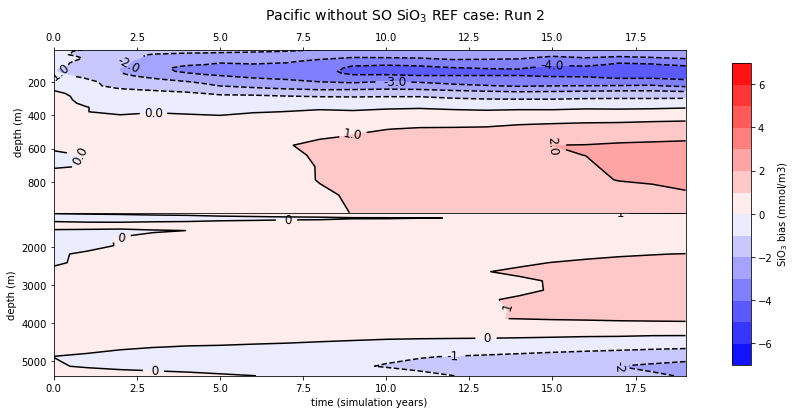

In [65]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Pacific without SO SiO$_3$ REF case: Run 2', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7]
pc=ax.contourf(years, z_top, diff_Pac2_ref_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_Pac2_ref_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Pac2_ref_bottom['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_Pac2_ref_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ bias (mmol/m3)')

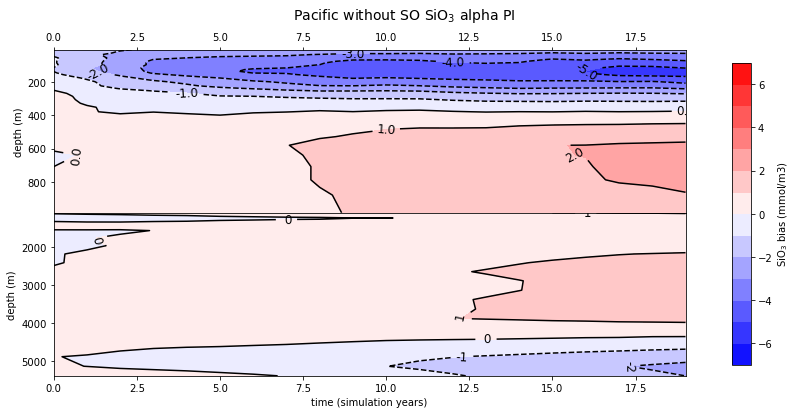

In [67]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Pacific without SO SiO$_3$ alpha PI', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7]
pc=ax.contourf(years, z_top, diff_Pac2_alphapi_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_Pac2_alphapi_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Pac2_alphapi_bottom['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_Pac2_alphapi_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ bias (mmol/m3)')

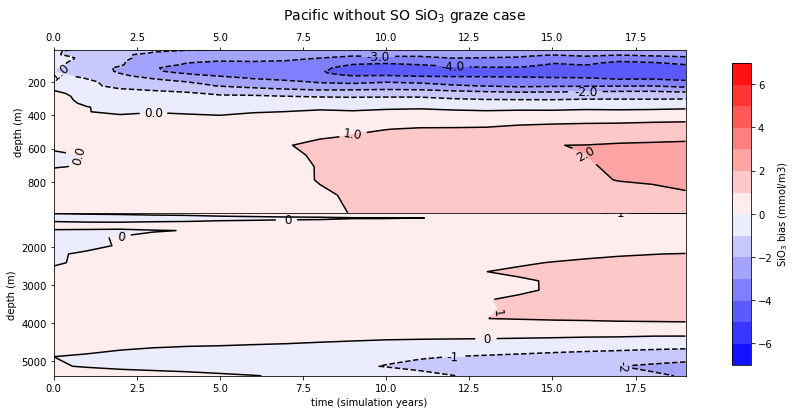

In [68]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Pacific without SO SiO$_3$ graze case', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7]
pc=ax.contourf(years, z_top, diff_Pac2_grz_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_Pac2_grz_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Pac2_grz_bottom['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_Pac2_grz_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ bias (mmol/m3)')

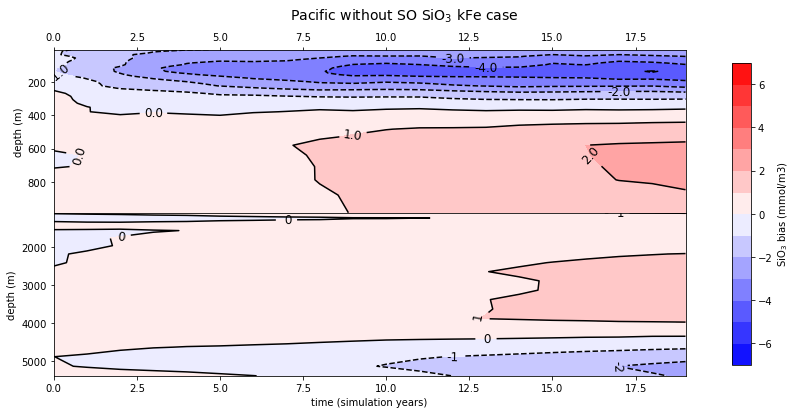

In [69]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Pacific without SO SiO$_3$ kFe case', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7]
pc=ax.contourf(years, z_top, diff_Pac2_kfe_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_Pac2_kfe_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Pac2_kfe_bottom['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_Pac2_kfe_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ bias (mmol/m3)')

### Surface nutrient maps

In [35]:
ds_mean_ref = ds_annmean_ts.isel(time=slice(14,20)).mean(dim='time')

In [ ]:
NO3_diff = ds_mean_ref.NO3 - ds_woa.NO3
PO4_diff = ds_mean_ref.PO4 - ds_woa.PO4
SiO3_diff = ds_mean_ref.SiO3 - ds_woa.SiO3

In [36]:
ds_mean_alphapi = ds_annmean_ts_alphapi.isel(time=slice(14,20)).mean(dim='time')
ds_mean_grz = ds_annmean_ts_grz.isel(time=slice(14,20)).mean(dim='time')
ds_mean_kfe = ds_annmean_ts_kfe.isel(time=slice(14,20)).mean(dim='time')

In [ ]:
NO3_diff_alphapi = ds_mean_alphapi.NO3 - ds_woa.NO3
PO4_diff_alphapi = ds_mean_alphapi.PO4 - ds_woa.PO4
SiO3_diff_alphapi = ds_mean_alphapi.SiO3 - ds_woa.SiO3

In [33]:
NO3_diff_grz = ds_mean_grz.NO3 - ds_woa.NO3
PO4_diff_grz = ds_mean_grz.PO4 - ds_woa.PO4
SiO3_diff_grz = ds_mean_grz.SiO3 - ds_woa.SiO3

In [34]:
NO3_diff_kfe = ds_mean_kfe.NO3 - ds_woa.NO3
PO4_diff_kfe = ds_mean_kfe.PO4 - ds_woa.PO4
SiO3_diff_kfe = ds_mean_kfe.SiO3 - ds_woa.SiO3

#### Calculate global RSME

In [40]:
ref_rmse_no3 = esmlab.statistics.weighted_rmsd(ds_mean_ref.NO3.isel(z_t=0), ds_woa.NO3.isel(z_t=0), dim=['nlat', 'nlon'], weights=area).compute()
ref_rmse_no3.values

array(2.17717226)

In [42]:
ref_rmse_sio3 = esmlab.statistics.weighted_rmsd(ds_mean_ref.SiO3.isel(z_t=0), ds_woa.SiO3.isel(z_t=0), dim=['nlat', 'nlon'], weights=area).compute()
ref_rmse_sio3.values

array(6.39582222)

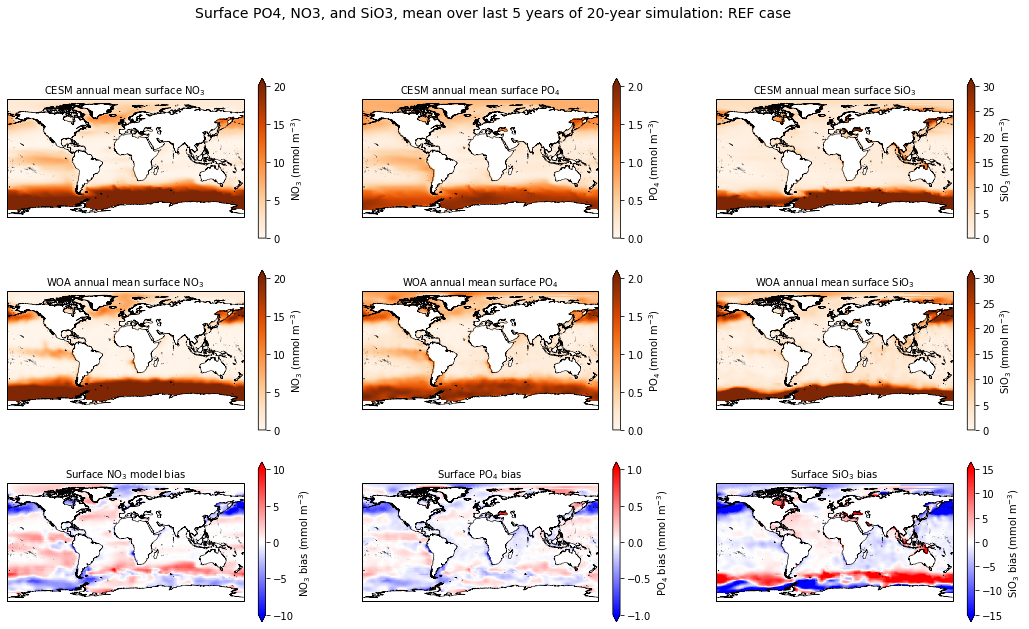

In [35]:
fig = plt.figure(figsize=(18,10))
plt.suptitle('Surface PO4, NO3, and SiO3, mean over last 5 years of 20-year simulation: REF case', fontsize=14)

####################NO3
#COLUMN 1  - NO3
#---- CESM panel
ax = fig.add_subplot(3,3,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface NO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_mean_ref.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,4, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface NO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,7, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface NO$_3$ model bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 NO3_diff.isel(z_t=0), vmin=-10, vmax=10, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')



####################PO4
#---- CESM panel
ax = fig.add_subplot(3,3,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface PO$_4$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_mean_ref.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,5, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface PO$_4$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,8, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface PO$_4$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 PO4_diff.isel(z_t=0), vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')



####################SiO3
#---- CESM panel
ax = fig.add_subplot(3,3,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface SiO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_mean_ref.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,6, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface SiO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,9, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface SiO$_3$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 SiO3_diff.isel(z_t=0), 
                  vmin=-15, vmax=15, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='SiO$_3$ bias (mmol m$^{-3}$)')



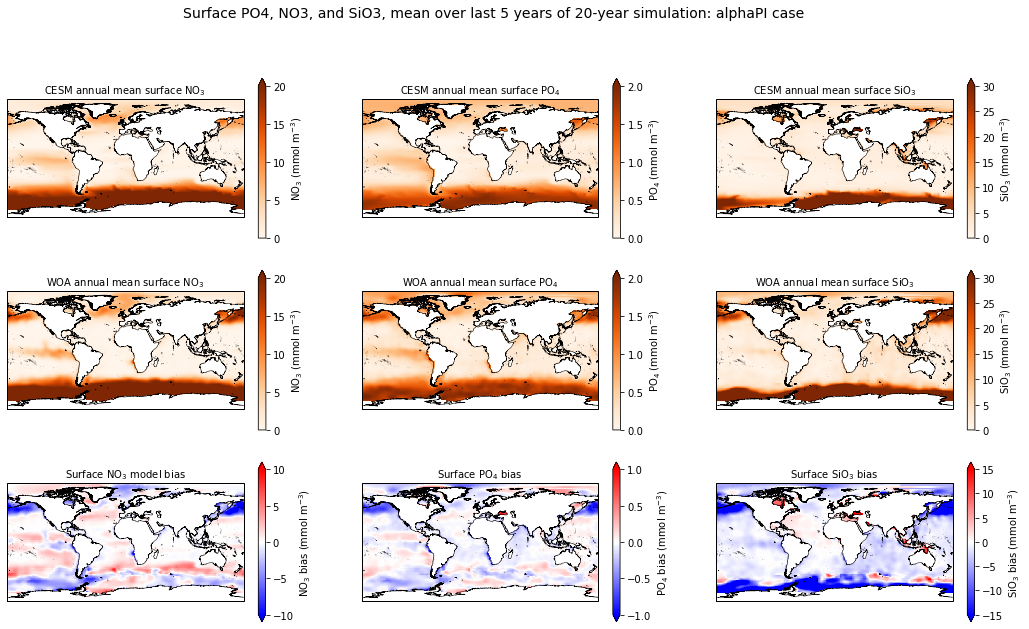

In [36]:
fig = plt.figure(figsize=(18,10))
plt.suptitle('Surface PO4, NO3, and SiO3, mean over last 5 years of 20-year simulation: alphaPI case', fontsize=14)

####################NO3
#COLUMN 1  - NO3
#---- CESM panel
ax = fig.add_subplot(3,3,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface NO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_mean_alphapi.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,4, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface NO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,7, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface NO$_3$ model bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 NO3_diff_alphapi.isel(z_t=0), vmin=-10, vmax=10, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')



####################PO4
#---- CESM panel
ax = fig.add_subplot(3,3,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface PO$_4$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_mean_alphapi.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,5, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface PO$_4$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,8, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface PO$_4$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 PO4_diff_alphapi.isel(z_t=0), vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')



####################SiO3
#---- CESM panel
ax = fig.add_subplot(3,3,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface SiO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_mean_alphapi.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,6, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface SiO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,9, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface SiO$_3$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 SiO3_diff_alphapi.isel(z_t=0), 
                  vmin=-15, vmax=15, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='SiO$_3$ bias (mmol m$^{-3}$)')



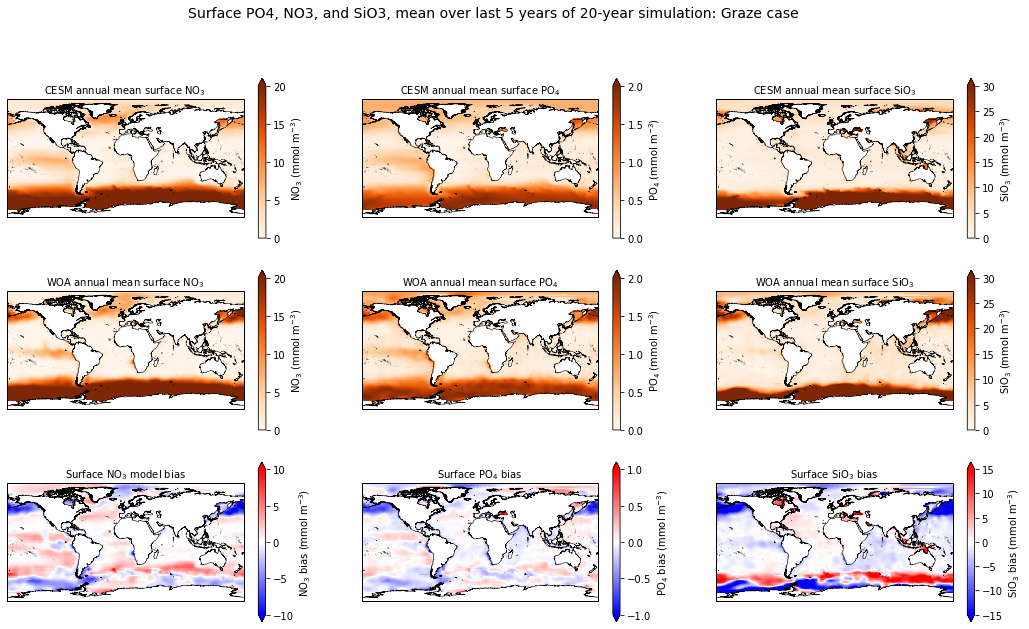

In [37]:
fig = plt.figure(figsize=(18,10))
plt.suptitle('Surface PO4, NO3, and SiO3, mean over last 5 years of 20-year simulation: Graze case', fontsize=14)

####################NO3
#COLUMN 1  - NO3
#---- CESM panel
ax = fig.add_subplot(3,3,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface NO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_mean_grz.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,4, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface NO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,7, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface NO$_3$ model bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 NO3_diff_grz.isel(z_t=0), vmin=-10, vmax=10, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')



####################PO4
#---- CESM panel
ax = fig.add_subplot(3,3,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface PO$_4$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_mean_grz.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,5, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface PO$_4$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,8, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface PO$_4$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 PO4_diff_grz.isel(z_t=0), vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')



####################SiO3
#---- CESM panel
ax = fig.add_subplot(3,3,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface SiO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_mean_grz.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,6, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface SiO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,9, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface SiO$_3$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 SiO3_diff_grz.isel(z_t=0), 
                  vmin=-15, vmax=15, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='SiO$_3$ bias (mmol m$^{-3}$)')



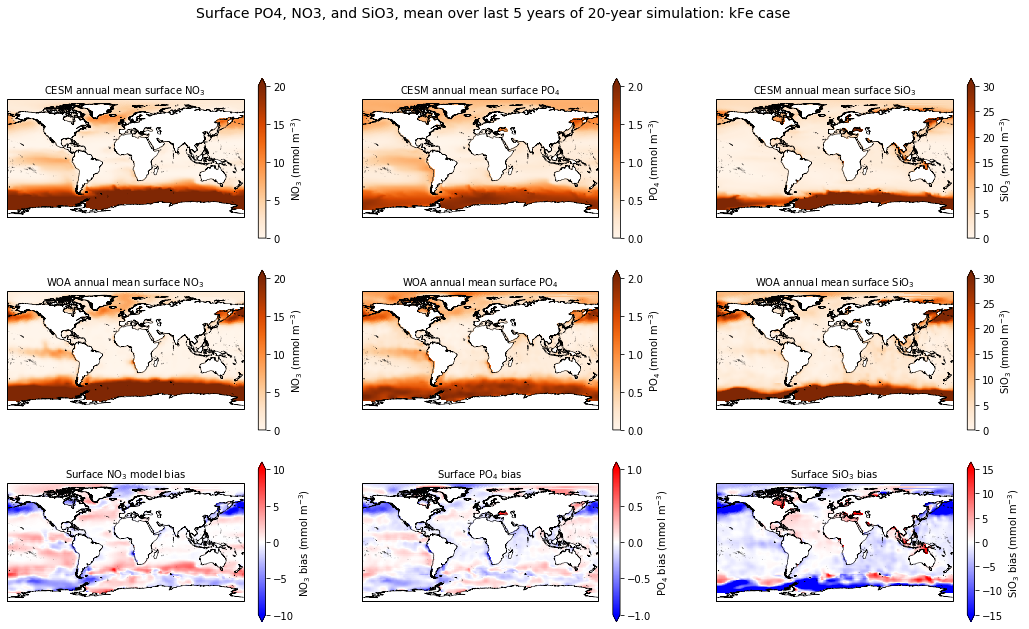

In [38]:
fig = plt.figure(figsize=(18,10))
plt.suptitle('Surface PO4, NO3, and SiO3, mean over last 5 years of 20-year simulation: kFe case', fontsize=14)

####################NO3
#COLUMN 1  - NO3
#---- CESM panel
ax = fig.add_subplot(3,3,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface NO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_mean_kfe.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,4, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface NO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,7, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface NO$_3$ model bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 NO3_diff_kfe.isel(z_t=0), vmin=-10, vmax=10, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')



####################PO4
#---- CESM panel
ax = fig.add_subplot(3,3,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface PO$_4$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_mean_kfe.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,5, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface PO$_4$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,8, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface PO$_4$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 PO4_diff_kfe.isel(z_t=0), vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')



####################SiO3
#---- CESM panel
ax = fig.add_subplot(3,3,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface SiO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_mean_kfe.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,6, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface SiO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,9, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface SiO$_3$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 SiO3_diff_kfe.isel(z_t=0), 
                  vmin=-15, vmax=15, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='SiO$_3$ bias (mmol m$^{-3}$)')

